<a href="https://colab.research.google.com/github/dolmani38/ai_corona/blob/master/analysis_corona_0505.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1. Forecast with numeric timeseries data
# 1.1 Roaming Data의 load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
# custom R2-score metrics for keras backend
from keras import backend as K

def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def plot_mae(hist):
    plt.plot(hist.history['mae'])
    plt.title('mean_absolute_error')
    plt.ylabel('mae')
    plt.xlabel('Epoch')
    plt.legend(['mae'], loc='upper right')
    plt.show()

def plot_r2(hist):
    plt.plot(hist.history['r2'])
    plt.title('R square')
    plt.ylabel('R^2')
    plt.xlabel('Epoch')
    #plt.legend(['mae'], loc='upper right')
    plt.show()

def compare_backdata(predit_y):
    predit = []
    for forecast in range(forecast_days):
        predit.append(list(np.concatenate((np.zeros(window+ forecast), predit_y[:,forecast],np.zeros(forecast_days-forecast-1)), axis=0)))
    # 예측치를 chart에 같이 그려서 확인
    comp_ds = raw_ds.copy()
    comp_ds['predict_arrival_1'] = predit[0]
    comp_ds['predict_arrival_15'] = predit[14]
    comp_ds.plot(y=['total','predict_arrival_1','predict_arrival_15'],figsize=(16,8))

def display_result(predit_y):
    predic_ds = []
    # 로밍등록자는 실 입국자의 약 24%에 해당되므로.. 이를 보정 처리 한다.
    #predit_y1 = predit_y * 100/24
    from datetime import datetime, timedelta
    last_date = raw_ds.index[-1]
    for predict_count in predit_y[0]:
        last_date += timedelta(days=1)
        predic_ds.append({'date':last_date,'roaming register forecate':predict_count, 'immigrantion forecast':int(predict_count * 100/24)})
    predic_ds = pd.DataFrame(predic_ds)
    predic_ds.plot(x='date',y='immigrantion forecast',kind='bar')
    return predic_ds

class VerboseCallback(keras.callbacks.Callback):
    def __init__(self,epoch):
        self.epoch = epoch
        self.progress("learning:",0,[])
        
    def progress(self,text,current=0,log=None):
        pg = ['=' for i in range(current)] + ['.' for i in range(self.epoch-current)]
        print("\r" + str(text) + "[{}] {}/{} {}".format(''.join(pg),current,self.epoch, ('' if log is None else log)), end="", flush=True)
        if self.epoch-current == 0:
            print("")        
            
    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:",epoch+1,logs)



Using TensorFlow backend.


In [3]:
#공개된 Roaming Dataset을 읽고, 중간 중간 나온것을 합친다.
rm1 = pd.read_csv("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0406/Roaming_data.csv",encoding="utf-8")
rm2 = pd.read_csv("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0429/Roaming_data.csv",encoding="utf-8")
rm = pd.concat([rm1, rm2], ignore_index=True, sort=False)

# 합친 Dataset의 내용 확인
rm

,return,iso,arrival,departure,count
0,20200131,ad,20200130,20200130,3
1,20200131,ae,20191231,20200125,3
2,20200131,ae,20191231,20200131,3
3,20200131,ae,20200102,20200102,3
4,20200131,ae,20200104,20200131,3
...,...,...,...,...,...
217800,20200401,vn,20200330,20200401,3
217801,20200401,vn,20200331,20200331,20
217802,20200401,vn,20200331,20200401,6
217803,20200401,vn,20200401,20200401,45


In [4]:
# 1.2 Roaming Data에 대한 EDA
# 1.2.1 도착일을 기준으로 입국자(로밍등록자)의 합산

ar = pd.DataFrame(rm.groupby('arrival')['count'].sum())
ar['date'] =  ar.index.astype('object')
#date column을 datetime 으로 casting 한다.
ar['date'] =  pd.to_datetime(ar['date'], format='%Y%m%d')

# 날자별 입국자(로밍등록자) 정리 dataset 확인
ar

,count,date
arrival,,
20191031,91,2019-10-31
20191101,36,2019-11-01
20191102,120,2019-11-02
20191103,159,2019-11-03
20191104,179,2019-11-04
...,...,...
20200424,711,2020-04-24
20200425,463,2020-04-25
20200426,447,2020-04-26


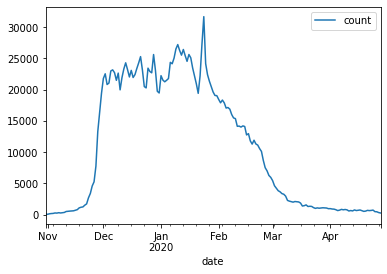

In [5]:
# 1.2.2 입국자(로밍등록자) 추세 chart 확인
ar.plot(x='date',y='count')

In [6]:
# 1.3 Roaming Data의 전처리
# 1.3.1 iso 별로 재배열

ar_iso = pd.DataFrame(rm.groupby(['arrival','iso'])['count'].sum())
rows = []
date = None
r = None
for row in ar_iso.iterrows():
    if date == row[0][0]:
        pass
    else:
        if not r is None:
            rows.append(r)
        r = {}
    r['arrival'] = row[0][0]
    r[row[0][1]] = row[1][0]
    date = row[0][0]
rows.append(r)
ds_iso = pd.DataFrame(rows)
ds_iso.fillna(0, inplace=True)
ds_iso = ds_iso.set_index('arrival')
ds_iso['total'] = ar['count']
ds_iso.index =  ds_iso.index.astype('object')
#index을 datetime 으로 casting 한다.
ds_iso.index =  pd.to_datetime(ds_iso.index, format='%Y%m%d')
ds_iso

,ae,at,cn,de,hk,jp,kh,kw,la,mm,my,no,pe,ph,pl,th,us,vn,hu,ma,mn,au,ch,fr,gb,in,iq,lk,qa,sg,uz,cz,dk,es,fi,id,nz,ru,sa,sk,...,tp,vu,zw,rs,tk,ug,bz,bo,cy,na,pg,rw,bt,lr,mz,pr,tg,mk,an,cv,tt,md,ad,ga,gn,re,ky,bf,bj,cf,tc,ls,td,mr,to,ws,gm,ye,ml,total
arrival,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-31,3.0,3.0,20,3.0,6.0,6,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,8,12.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91
2019-11-01,0.0,0.0,6,3.0,0.0,3,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,9,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36
2019-11-02,0.0,0.0,26,6.0,3.0,9,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,6,19.0,3.0,0.0,0.0,0.0,6.0,3.0,6.0,3.0,6.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120
2019-11-03,3.0,3.0,30,0.0,12.0,14,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,3.0,13,21.0,6.0,3.0,0.0,0.0,0.0,3.0,0.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,9.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159
2019-11-04,12.0,3.0,40,3.0,3.0,10,0.0,0.0,0.0,0.0,6.0,0.0,0.0,6.0,0.0,6,24.0,9.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,6.0,6.0,3.0,0.0,0.0,3.0,3.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-24,0.0,12.0,84,34.0,19.0,157,0.0,0.0,0.0,3.0,3.0,0.0,0.0,30.0,0.0,18,62.0,44.0,6.0,0.0,3.0,3.0,0.0,9.0,12.0,6.0,0.0,0.0,0.0,6.0,6.0,0.0,6.0,3.0,0.0,28.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,711
2020-04-25,0.0,9.0,39,15.0,4.0,111,21.0,0.0,0.0,6.0,3.0,0.0,0.0,6.0,0.0,6,73.0,27.0,0.0,0.0,3.0,0.0,0.0,0.0,6.0,3.0,0.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,463
2020-04-26,0.0,0.0,42,14.0,10.0,98,6.0,0.0,0.0,0.0,3.0,0.0,0.0,12.0,0.0,3,50.0,40.0,3.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,27.0,0.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,447


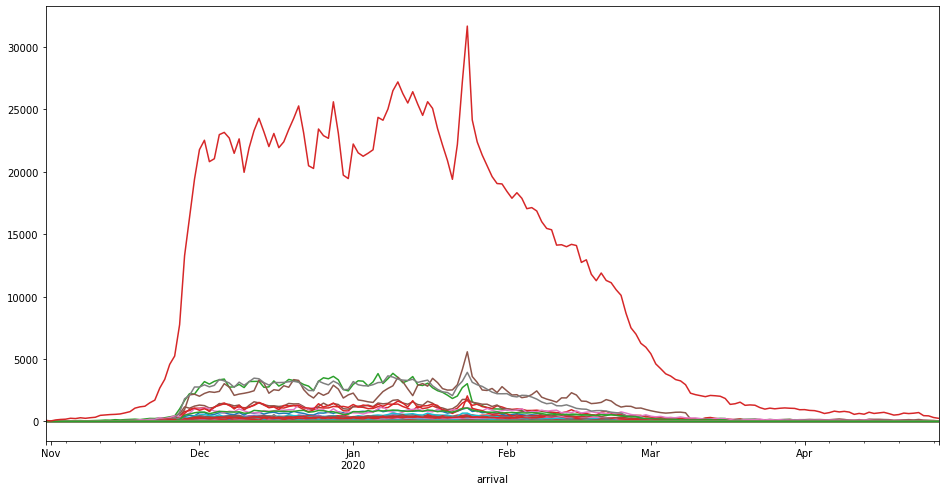

In [7]:
ds_iso.plot(legend=False,figsize=(16,8))

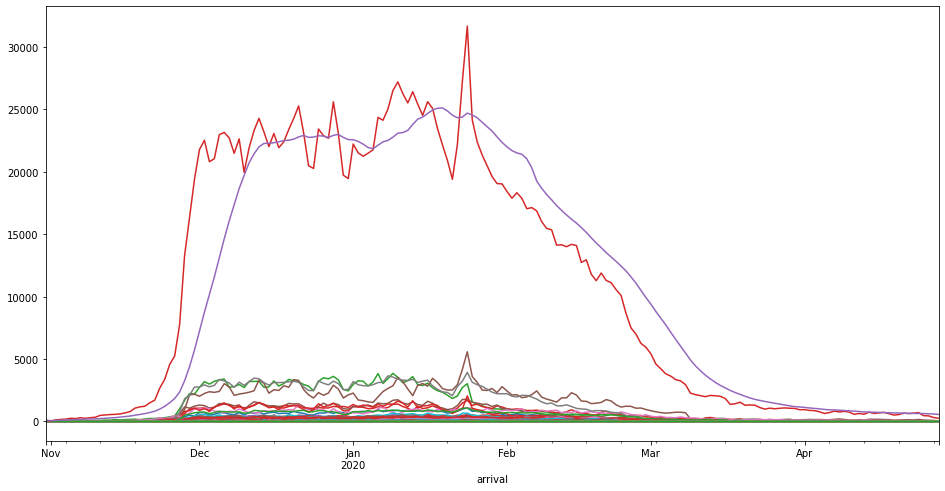

In [8]:
# 1.3.2 2주 (14일) 평균 추세 추가.
raw_ds = ds_iso.copy()
raw_ds['arrival_14ma'] = raw_ds['total'].rolling(window=14, min_periods=0).mean()
raw_ds.plot(legend=False,figsize=(16,8))

In [0]:
# 1.3.3 Trainingset의 구성

# Time-series CNN을 적용하기 위한 전처리
# 1D Convolution을 적용하기 위해.

import numpy as np

# window를 30일로 설정 -> 그냥 잡은 수치
window = 30
#입력 feature 개수.
size = len(raw_ds.columns) - 1 # totoal column 제외
#향후 15일 예측
forecast_days = 15


train_org_y = raw_ds['total'].to_numpy()
data = (raw_ds.drop(columns=['total'])).to_numpy()

train_x = []
train_y = []

for i in range(data.shape[0]-window-forecast_days + 1):
    sub_x = []
    for j in range(window):
        sub_x.append(data[i+j,:])
    train_x.append(sub_x)

    sub_y = []
    for z in range(forecast_days):
        sub_y.append(train_org_y[i + window + z])
    train_y.append(sub_y)

#train_x ,train_y의 준비
train_x = np.asarray(train_x)
train_x = train_x.reshape(-1,window,size)
train_y = np.asarray(train_y)

test_x = data[data.shape[0]-window:data.shape[0],:]

In [10]:
#train_x ,train_y의 내용 확인.
train_x.shape, train_y.shape, test_x.shape

((137, 30, 174), (137, 15), (30, 174))

In [11]:
# 1.4 CNN model 구성 


# 이게 최적의 layer 구성인지는 모름... 일반적/직관적으로 layer 설정 
import keras
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D
from keras.models import Sequential

model = Sequential()
model.add(Conv1D(128,4, input_shape=(window, size),padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, 4,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

#model.add(Conv1D(32, 4,padding="same"))
#model.add(Activation('relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(256))
model.add(Dense(forecast_days))
model.add(Activation('linear'))

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 30, 128)           89216     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 64)            32832     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 64)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 448)              

In [12]:
# 1.5 model training
# 1.5.1 model training

#학습 시작...
epochs=100
hist = model.fit(train_x, train_y, epochs=epochs,verbose=0, callbacks=[VerboseCallback(epochs)])

learning:[====================================================================================================] 100/100 {'loss': 1506689.3827554744, 'mae': 765.6697, 'r2': 0.98550034}


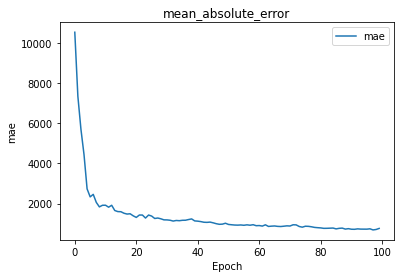

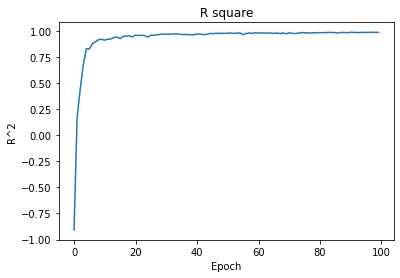

In [13]:
# 1.5.2 학습에 대한 mean_absolute_error 확인.
plot_mae(hist)
plot_r2(hist) 

In [14]:
# 1.5.3 trainset에 의한 과거 data의 예측 입국자 count 
predit_y = model.predict(train_x)
predit_y,predit_y.shape

(array([[19629.186  , 20513.42   , 20839.527  , ..., 22938.775  ,
         23109.82   , 22026.203  ],
        [21368.771  , 21937.957  , 22608.346  , ..., 24099.975  ,
         23934.494  , 23499.564  ],
        [21376.367  , 21725.914  , 22631.7    , ..., 23432.504  ,
         23131.547  , 23101.738  ],
        ...,
        [  638.6676 ,   627.87354,   593.9469 , ...,   394.84836,
           385.47598,   354.27643],
        [  619.5053 ,   609.6883 ,   579.90607, ...,   391.16006,
           367.08725,   346.4936 ],
        [  605.7458 ,   593.10626,   573.1424 , ...,   384.4495 ,
           374.15323,   348.6673 ]], dtype=float32), (137, 15))

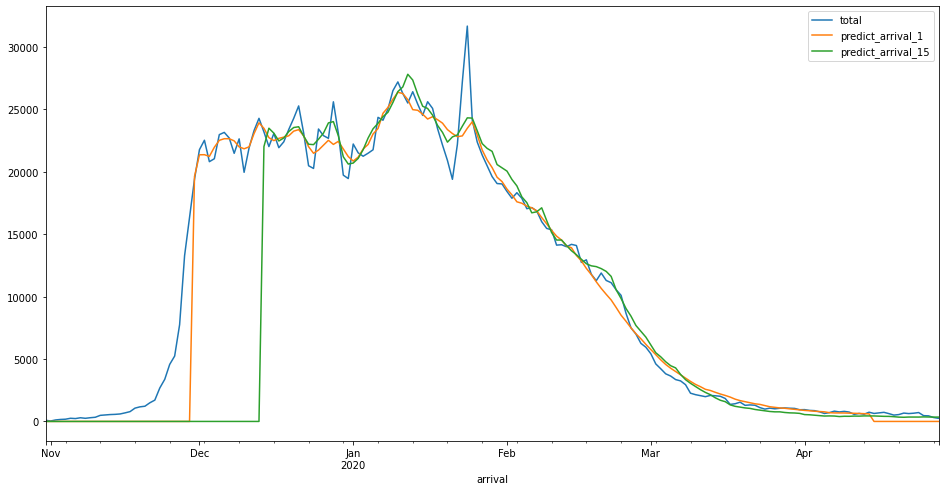

In [15]:
# 1.5.4 과거 Data에서 실등록자 count와 예측 count의 비교 

def compare_backdata(predit_y):
    predit = []
    for forecast in range(forecast_days):
        predit.append(list(np.concatenate((np.zeros(window+ forecast), predit_y[:,forecast],np.zeros(forecast_days-forecast-1)), axis=0)))
    # 예측치를 chart에 같이 그려서 확인
    comp_ds = raw_ds.copy()
    comp_ds['predict_arrival_1'] = predit[0]
    comp_ds['predict_arrival_15'] = predit[14]
    comp_ds.plot(y=['total','predict_arrival_1','predict_arrival_15'],figsize=(16,8))

compare_backdata(predit_y)

In [16]:
# 1.6  향후 15일 예측
# 1.6.1 testset (마지막 30일)의 inference

# trainset의 마지막 날에서 15일까지의 예측
# 마지막 30일치 정보를 input으로...

test_x = test_x.reshape(-1,window,size)
predit_y = model.predict(test_x)
predit_y, predit_y.shape

(array([[440.4489 , 427.46353, 434.88425, 398.3147 , 388.4964 , 364.70764,
         352.16306, 344.0168 , 319.24457, 309.5812 , 299.56473, 248.52821,
         246.15495, 240.01086, 244.68347]], dtype=float32), (1, 15))

,date,roaming register forecate,immigrantion forecast
0,2020-04-29,440.448914,1835
1,2020-04-30,427.463531,1781
2,2020-05-01,434.884247,1812
3,2020-05-02,398.314697,1659
4,2020-05-03,388.496399,1618
5,2020-05-04,364.707642,1519
6,2020-05-05,352.163055,1467
7,2020-05-06,344.016815,1433
8,2020-05-07,319.244568,1330
9,2020-05-08,309.581207,1289


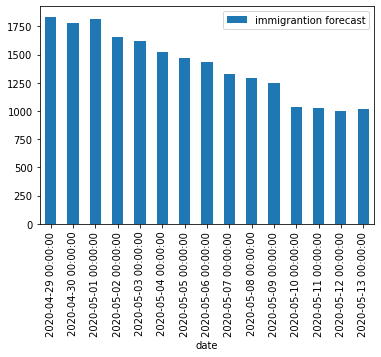

In [17]:
# 1.6.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출

display_result(predit_y)

In [18]:

# 	2.1 News Data의 load

# 뉴스 기사 정보를 읽어서... 나뉘어 있는 Dataset을 합친다.
ns1 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0406/NewsList.xls")
ns2 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0429/NewsList.xls")
ns =pd.concat([ns1, ns2], ignore_index=True, sort=False)
ns

,파일명,제목,URL,수집일자,게시일자,채널명,감염병명,분류명
0,AFRO2019120200003,WHO supports Angola’s Government efforts to en...,https://www.afro.who.int/news/who-supports-ang...,2019-12-02 21:00:16.0,2019-12-02 00:00:00,AFRO,Poliomyelitis,Viral
1,AFRO2019120300001,African First Ladies laud progress against HIV...,https://www.afro.who.int/news/african-first-la...,2019-12-03 00:00:17.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
2,AFRO2019120300002,Eritrea Observed World AIDS Day 2019,https://www.afro.who.int/news/eritrea-observed...,2019-12-03 00:00:18.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
3,AFRO2019120400003,West and Central Africa Expands Access to HIV ...,https://www.afro.who.int/news/west-and-central...,2019-12-04 03:00:14.0,2019-12-03 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
4,AFRO2019120400004,Nearly 23 million voluntary male medical circu...,https://www.afro.who.int/news/nearly-23-millio...,2019-12-04 22:00:14.0,2019-12-04 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
...,...,...,...,...,...,...,...,...
103822,XWFB2020040900020,"Ching Ming remembrance, home country forever! ...",http://wsjkw.sh.gov.cn/xwfb/20200404/2f54e0e14...,2020-04-09 16:05:21.0,2020-04-04 00:00:00,Shanghai Municioal Health Commission,COVID-19,Viral
103823,ZWYW2020041000002,Guangdong Provincial Health Commission notifie...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-10 18:00:45.0,2020-04-10 00:00:00,Health Commission of Guangdong Province,Dengue fever,Viral
103824,ZWYW2020041500002,Guangdong Provincial Health Commission announc...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-15 23:01:04.0,2020-04-15 00:00:00,Health Commission of Guangdong Province,Influenza,Viral
103825,ZWYW2020041500003,Guangdong Provincial Health Commission release...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-15 23:01:13.0,2020-04-15 00:00:00,Health Commission of Guangdong Province,Influenza,Viral


In [19]:
# 	2.2 News Data에 대한 EDA
# 		2.2.1 게시일을 기준으로 News buzz의 합산

cov_news = ns.loc[ns['감염병명'] == 'COVID-19']
cov_news['게시일자'] =  cov_news['게시일자'].str[:10]
cov_buz = pd.DataFrame(cov_news.groupby('게시일자')['감염병명'].count())
cov_buz = cov_buz.loc[cov_buz.index >= '2019-10-31']
cov_buz['date'] = pd.to_datetime(cov_buz.index, format='%Y-%m-%d')
cov_buz = cov_buz.rename(columns={"감염병명":"buz_count"})
cov_buz

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,buz_count,date
게시일자,,
2019-12-01,1,2019-12-01
2019-12-14,2,2019-12-14
2019-12-30,3,2019-12-30
2019-12-31,5,2019-12-31
2020-01-02,1,2020-01-02
...,...,...
2020-04-26,1176,2020-04-26
2020-04-27,1353,2020-04-27
2020-04-28,999,2020-04-28


In [20]:
# 		2.2.2 하루 최대 buzz count 추출

max_buz_per_day = cov_buz['buz_count'].max()
max_buz_per_day

1948

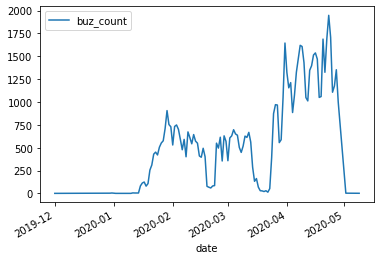

In [21]:
# 		2.2.3 News buzz 추세 Chart

cov_buz.plot(x='date',y='buz_count')

In [22]:
# 	2.3 News Data의 전처리
#		2.3.1 News Data의 doc2vec 처리

!pip install nltk
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [23]:
#			2.3.1.1 document의 tokenize & tagging
# 실 Contents는 사용하지 않고 title만 doc2vec 처리...
tagged_data = []
for row in cov_news.iterrows():
    file_name = row[1][0]
    title = str(row[1][1])
    pub_datetime = row[1][4]
    tagged_data.append(TaggedDocument(words=word_tokenize(title.lower()), tags=[file_name]))
    
len(tagged_data)

73752

In [24]:
#			2.3.1.2 doc2vec model training
# 시간 무지 걸림... 돌리고 커피 한잔 마시기.

max_epochs = 10 # 이건 나중에 100 정도로 수정...
vec_size = 40 # 나중에 증가 시킨다.contents를 사용하는 경우, 500~1000정도 ?? 하지만 학습시간은 무지 걸릴거임.
alpha = 0.025

d2v_model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
d2v_model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    d2v_model.train(tagged_data,
                total_examples=d2v_model.corpus_count,
                epochs=d2v_model.epochs )
    # decrease the learning rate
    d2v_model.alpha -= 0.0002
    # fix the learning rate, no decay
    d2v_model.min_alpha = d2v_model.alpha

d2v_model.save("d2v.model")

print("Model Saved")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Model Saved


In [25]:
# doc2vec 모델 학습 결과 확인..
from gensim.models.doc2vec import Doc2Vec

d2v_model= Doc2Vec.load("d2v.model")

# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(d2v_model.docvecs['AFRO2020013100001'])

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[-0.4784521   0.08756325  0.9756568  -0.08308656 -0.34749117  1.4846277
  1.5606172  -0.7224288  -1.2590874   0.34851867 -0.08449102  0.15542409
 -0.49350893 -0.9332885   1.2693937  -0.2596936  -0.39089355 -0.28434712
  0.42659447 -0.2039603  -0.85942847 -0.6466132   0.76977324 -0.3634393
  0.0826329  -0.33771977  0.21351945  0.34054193 -0.20795508 -0.13243195
  0.5847539  -0.18031994  1.0230327   0.49244076 -1.3795542   0.22327934
  1.0896813  -0.72125244  0.18504606 -0.30077565]


In [30]:
#		2.3.4 원시(origin) Trainset의 구성

# doc2vec을 feature로 하는 원시 학습셋을 구성한다.
# 이때, 입국일자을 기준으로 Set을 만드는데...
# 입국일에 news가 없을 때도 있어서, 일관성 있는 양질의 학습셋이 되기는 어려울 듯...
# 준대로 해야지 어쩔 수 없음.

max_buz_per_day = 300 # 하루에 최대 300개의 뉴스를 본다. 나중에 실재 최대치까지 증가..
cov_news['게시일자'] = pd.to_datetime(cov_news['게시일자'], format='%Y-%m-%d')
news_metric = []
from datetime import datetime, timedelta
import numpy as np
# 날짜별 (1948,40) 구성
for row in ar.iterrows():
    date = row[1][1]#datetime(2019,12,31)
    selected_ns = cov_news.loc[cov_news['게시일자'] >= date].loc[cov_news['게시일자'] < (date + timedelta(days=1))]
    #print(date,selected_ns.shape)
    if selected_ns.shape[0] == 0:
        # news가 없는 경우..
        news_metric.append(np.zeros((max_buz_per_day,vec_size)))
    else:
        docv = []
        for nrow in selected_ns.iterrows():
            #print('tag name:',nrow[1][0])
            if len(docv) < max_buz_per_day:
                docv.append(d2v_model.docvecs[nrow[1][0]])
        if len(docv) < max_buz_per_day:
            for i in range(max_buz_per_day-selected_ns.shape[0]):
                docv.append(np.zeros(vec_size))
        news_metric.append(docv)
        
train_temp_x = np.asarray(news_metric)
train_temp_x.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(181, 300, 40)

In [31]:
# 학습셋의 내용 확인...
train_temp_x[162]

array([[ 0.82720584,  0.20333642,  0.83214629, ..., -0.25581348,
        -0.00991366,  0.69285524],
       [ 0.16599661,  0.07984487,  0.47101194, ...,  0.08681227,
         0.10843098, -0.7535243 ],
       [ 0.30005604,  0.14496244,  0.24630764, ..., -0.12278109,
         0.08017104, -0.21129428],
       ...,
       [ 0.58632571,  0.10372421,  0.03976285, ...,  0.3564029 ,
         0.22607483, -0.6464023 ],
       [ 1.3725878 ,  0.89976907,  0.6194002 , ...,  1.42732525,
         0.22839159, -0.87070274],
       [ 0.57435054,  0.11386118,  0.46425098, ..., -0.09209394,
        -0.00717201, -1.39651465]])

In [42]:
# 학습셋의 label... 원시 train_temp_y의 구성
train_temp_y = np.insert(np.asanyarray(np.diff(ar['count'])),0,0)
train_temp_y[1] = 0
train_temp_y.shape


(181,)

In [72]:
#	2.4 doc2vec에 의한 Regression Test (Not forecast)
#		2.4.1 doc2vec의 Timeseries model 구성

# 일단, news regression의 설명력을 확인하기 위해...원시 학습을 test 한다.
import keras
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D
from keras.models import Sequential

model = Sequential()
model.add(Conv1D(128,2, input_shape=(max_buz_per_day,vec_size),padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, 2,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, 2,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128))
model.add(Dense(1))
model.add(Activation('linear'))

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 300, 128)          10368     
_________________________________________________________________
activation_16 (Activation)   (None, 300, 128)          0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 150, 128)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 150, 64)           16448     
_________________________________________________________________
activation_17 (Activation)   (None, 150, 64)           0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 75, 64)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 75, 32)           

In [73]:
#		2.4.2 원시(origin) Trainset으로 model training

epochs=100
hist = model.fit(train_temp_x, train_temp_y, epochs=epochs,verbose=0, callbacks=[VerboseCallback(epochs)])

learning:[====================================================================================================] 100/100 {'loss': 754150.585980663, 'mae': 422.195, 'r2': 0.48113963}


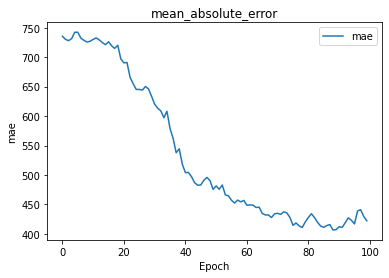

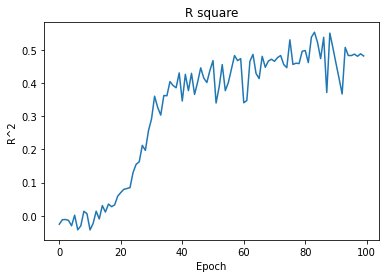

In [74]:
#		2.4.3 학습에 대한 mean_absolute_error 확인.

plot_mae(hist)
plot_r2(hist)

In [0]:
#		2.4.4 trainset에 의한 과거 data의 예측 입국자 count 
predit_y = model.predict(train_temp_x)


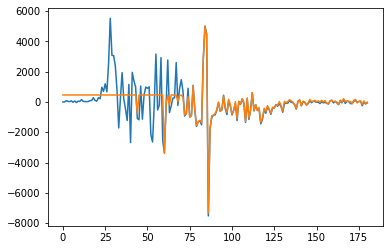

In [76]:
#		2.4.5 실등록자 count와 news기반 예측 count의 비교 chart

plt.plot(train_temp_y)
plt.plot(predit_y)


In [0]:
#	2.5 doc2vec에 의한 Forecast regression
#		2.5.1 doc2vec의 Window 적용 Timeseries Trainset의 구성

# 2D Convolution을 적용하여 마치 Image를 convolution 하듯이 학습할 것임
# window의 depth를 image의 channel 처럼 사용
# tensorflow는 image의 chennel을 channel_last로 사용, 
# 이것을 맞추기 위해 moveaxis 를 적용할 것임
# 여기 돌다가 colab 다운 잘됨... 다운 되면 처음부터 다시!

from numpy import moveaxis
# window를 30일로 설정 -> 그냥 잡은 수치
news_window = 30
#향후 15일 예측
news_forecast_days = 15

# 원시 trainset의 사용...
train_news_org_y = train_temp_y
data = train_temp_x

train_news_x = []
train_news_y = []

for i in range(data.shape[0]-news_window-news_forecast_days + 1):
    sub_x = []
    for j in range(news_window):
        sub_x.append(data[i+j,:,:])
    # change channels first to channels last format
    sub_x = np.asarray(sub_x)
    sub_x = moveaxis(sub_x, 0, 2)        
    train_news_x.append(sub_x)

    sub_y = []
    for z in range(news_forecast_days):
        sub_y.append(train_news_org_y[i + news_window + z])
    train_news_y.append(sub_y)

#train_news_x ,train_news_y 준비
train_news_x = np.asarray(train_news_x)
#train_news_x = train_news_x.reshape(-1,news_window,max_buz_per_day,vec_size)
train_news_y = np.asarray(train_news_y)

test_news_x = np.asarray(data[data.shape[0]-news_window:data.shape[0],:,:])
test_news_x = moveaxis(test_news_x, 0, 2) 

In [78]:
#train_news_x ,train_news_y (사실이거는 그냥 train_y와 동일...)의 내용 확인.
train_news_x.shape,  train_news_y.shape, test_news_x.shape

((137, 300, 40, 30), (137, 15), (300, 40, 30))

In [109]:
#		2.5.2 doc2vec Window 의 Timeseries model 구성

# 이게 최적의 layer 구성인지는 모름... 일반적/직관적으로 layer 설정 
# 정성적 비정형 데이터로 정량적 수치 데이터를 추정 하기 때문에... overfit 가능성이 큼
import keras
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

#keras.backend.set_image_data_format('channels_last')

model = Sequential()
model.add(Conv2D(64,(2,2), input_shape=(max_buz_per_day,vec_size,news_window)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(2,2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(8,(2,2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64,activation="linear"))
#model.add(Dropout(0.3))
#model.add(Dense(15))
model.add(Dense(news_forecast_days))
model.add(Activation('linear'))

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])

model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 299, 39, 64)       7744      
_________________________________________________________________
activation_24 (Activation)   (None, 299, 39, 64)       0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 149, 19, 64)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 148, 18, 32)       8224      
_________________________________________________________________
activation_25 (Activation)   (None, 148, 18, 32)       0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 74, 9, 32)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 73, 8, 8)         

In [110]:
#		2.5.3 doc2vec의 Window 적용 Timeseries Trainset으로 model training

epochs=200
hist = model.fit(train_news_x, train_news_y, epochs=epochs,verbose=0, callbacks=[VerboseCallback(epochs)])


learning:[========================================================================================================================================================================================================] 200/200 {'loss': 1013053.2198905109, 'mae': 524.43884, 'r2': 0.3926827}


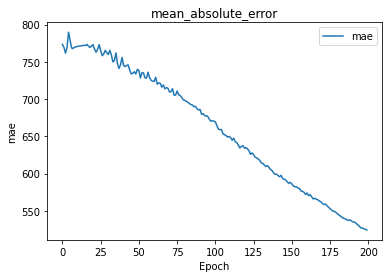

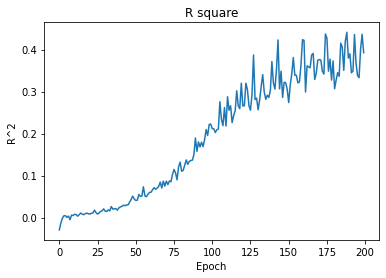

In [111]:
#		2.5.4 학습에 대한 mean_absolute_error 확인.

plot_mae(hist)
plot_r2(hist)

In [118]:
#		2.5.5 trainset에 의한 과거 data의 예측 입국자 추정 

predit_news_y = model.predict(train_news_x)
predit_news_y,predit_news_y.shape

(array([[ 1.16845310e+00,  8.76508594e-01,  9.21273291e-01, ...,
          1.25541484e+00,  8.62855017e-01,  1.17929444e-01],
        [ 1.16845310e+00,  8.76508594e-01,  9.21273291e-01, ...,
          1.25541484e+00,  8.62855017e-01,  1.17929444e-01],
        [ 1.16845310e+00,  8.76508594e-01,  9.21273291e-01, ...,
          1.25541484e+00,  8.62855017e-01,  1.17929444e-01],
        ...,
        [ 9.74435959e+01, -1.24377480e+02,  1.39214340e+02, ...,
         -8.72654152e+00, -1.05869728e+02, -5.10823898e+01],
        [ 4.87897568e+01,  1.72896179e+02,  6.05350037e+01, ...,
         -1.63013916e+02, -1.21083687e+02, -1.95945618e+02],
        [ 6.21967430e+01,  1.25222084e+02, -8.12957859e+00, ...,
         -1.64670166e+02, -1.58419388e+02, -1.15461342e+02]], dtype=float32),
 (137, 15))

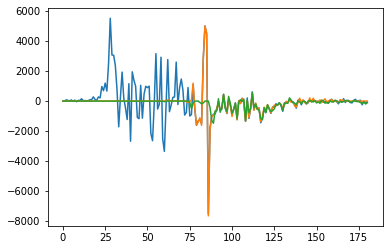

In [119]:
# window와 forecast_days에 의해 실제 날자와 차이나는 부분의 보정 처리...
predit = []
for forecast in range(forecast_days):
    predit.append(list(np.concatenate((np.zeros(window+ forecast), predit_news_y[:,forecast],np.zeros(forecast_days-forecast-1)), axis=0)))
    
plt.plot(train_temp_y)
plt.plot(predit[0])
plt.plot(predit[14])


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,org
0,1.000000,0.989190,0.987633,0.979355,0.979641,0.958425,0.919910,0.914259,0.868609,0.905292,0.615945,0.494796,0.541999,0.446289,0.310619,0.681278
1,0.989190,1.000000,0.994843,0.981935,0.983396,0.958099,0.921254,0.912030,0.857950,0.898299,0.611727,0.483448,0.532182,0.447046,0.315915,0.680764
2,0.987633,0.994843,1.000000,0.986515,0.986634,0.959254,0.924124,0.914126,0.870733,0.909557,0.624642,0.498706,0.540170,0.451602,0.331131,0.678244
3,0.979355,0.981935,0.986515,1.000000,0.986057,0.964451,0.932768,0.927865,0.868119,0.907377,0.632708,0.491742,0.533960,0.448765,0.329066,0.670714
4,0.979641,0.983396,0.986634,0.986057,1.000000,0.950502,0.902583,0.903246,0.869901,0.902837,0.621184,0.486106,0.517171,0.437093,0.324685,0.670040
5,0.958425,0.958099,0.959254,0.964451,0.950502,1.000000,0.963617,0.952023,0.821136,0.918416,0.636137,0.537833,0.564826,0.467295,0.346021,0.654461
6,0.919910,0.921254,0.924124,0.932768,0.902583,0.963617,1.000000,0.933442,0.759194,0.875073,0.701826,0.529985,0.584537,0.511277,0.360794,0.636392
7,0.914259,0.912030,0.914126,0.927865,0.903246,0.952023,0.933442,1.000000,0.866152,0.883208,0.712590,0.545968,0.637144,0.531736,0.373435,0.629398
8,0.868609,0.857950,0.870733,0.868119,0.869901,0.821136,0.759194,0.866152,1.000000,0.905173,0.618833,0.557151,0.645308,0.497540,0.359581,0.600638
9,0.905292,0.898299,0.909557,0.907377,0.902837,0.918416,0.875073,0.883208,0.905173,1.000000,0.612543,0.590055,0.627934,0.486086,0.368540,0.623680


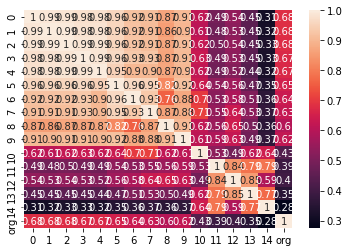

In [120]:
# 뉴스의 영향도가 몇일후에 나타나는지 찾는다.

import seaborn as sn

nds = pd.DataFrame(predit).T
nds['org'] = train_temp_y
corrMatrix = nds.corr()
sn.heatmap(corrMatrix, annot=True)
corrMatrix

In [121]:
# 	2.6  향후 15일 예측
# 		2.6.1 testset (마지막 30일)의 inference

test_news_x = test_news_x.reshape(-1,max_buz_per_day,vec_size,news_window)
predit_y = model.predict(test_news_x)
predit_y,predit_y.shape

(array([[ -685.9397 ,  -340.5744 ,   810.3507 ,  -286.7689 , -1060.9803 ,
          -508.30576,   260.69952,   179.82445,  -143.38809,   207.64194,
          -319.77374,  -321.9968 ,  -230.99107,    54.09254,    45.09423]],
       dtype=float32), (1, 15))

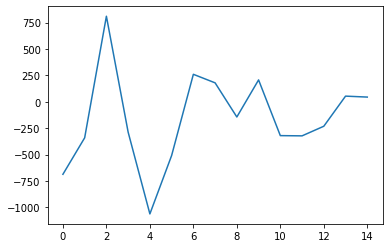

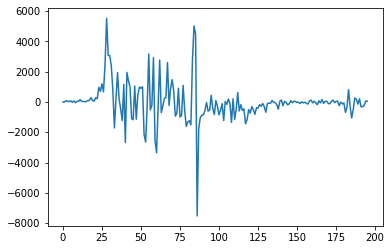

In [116]:
# 		2.6.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출
plt.plot(predit_y[0])
plt.show()
plt.plot(np.concatenate((train_temp_y,predit_y[0]), axis=0))
#display_result(predit_y)
plt.show()

In [0]:
# 이제 긴 학습을 해야 해서..
# 돌다가 죽을 것을 대비해서 입출력 dataset을 일단 저장 한다.

from numpy import save
# define data
data = np.asarray([train_x,train_y,test_x,train_news_x,train_news_y,test_news_x])
# save to npy file
save('dataset.npy', data)

In [0]:
if True==0:
    # load numpy array from npy file
    from numpy import load
    # load dict of arrays
    [train_x,train_y,test_x,train_news_x,train_news_y,test_news_x] = load('dataset.npy', allow_pickle=True)

train_x.shape

(137, 30, 174)

In [0]:
#	3.2 Numeric timeseries and unstructured timeseries combined model 구성
import keras
from keras import Input, Model
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, concatenate

# custom R2-score metrics for keras backend
from keras import backend as K

# define two sets of inputs
input_roaming = Input(shape=(window, size))
input_news = Input(shape=(max_buz_per_day,vec_size,news_window))

# 로밍등록자에 대한 1D Convilution layer 구성
x = Conv1D(128,4, activation="relu",padding="same")(input_roaming)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(64,4, activation="relu",padding="same")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(32,4, activation="relu",padding="same")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Model(inputs=input_roaming, outputs=x)


# news에 대한 2D Convolution layer 구성
y = Conv2D(64,(3,3), activation="relu")(input_news)
y = MaxPooling2D(pool_size=(3,3))(y)
y = Conv2D(32,(2,2), activation="relu")(y)
y = MaxPooling2D(pool_size=(3,3))(y)
y = Flatten()(y)
y = Dense(1024,activation="relu")(y)
#y = Dropout(0.5)(y)
y = Dense(32,activation="relu")(y)
y = Model(inputs=input_news, outputs=y)

# combine the output of the two branches
combined = concatenate([x.output, y.output])

# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(forecast_days, activation="linear")(combined)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])

print(model.summary())

model_json = model.to_json()
with open("combined_model.json", "w") as json_file:
    json_file.write(model_json)
json_file.close()

print("save to combined_model.json")

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 30, 174)      0                                            
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 30, 128)      89216       input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 300, 20, 30)  0                                            
__________________________________________________________________________________________________
max_pooling1d_19 (MaxPooling1D) (None, 15, 128)      0           conv1d_22[0][0]                  
___________________________________________________________________________________________

In [0]:
#	3.3 Numeric timeseries and unstructured timeseries data train

def train_combined_model(trial,epochs=30,verbose=0):
    from keras.models import model_from_json
    json_file = open("combined_model.json", "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae','acc'])
    #print(model.summary())
    print(str(trial),"th Trial")
    if verbose == 0:
        hist = model.fit([train_x,train_news_x], train_y, epochs=epochs,verbose=0,callbacks=[VerboseCallback(epochs)])
    else:
        hist = model.fit([train_x,train_news_x], train_y, epochs=epochs,verbose=1)
    return model,hist

model,hist = train_combined_model(1,epochs=2)

1 th Trial
learning:[==] 2/2 {'loss': 108401430.42335767, 'mae': 8234.738, 'acc': 0.38686132}


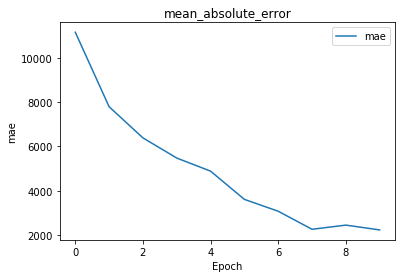

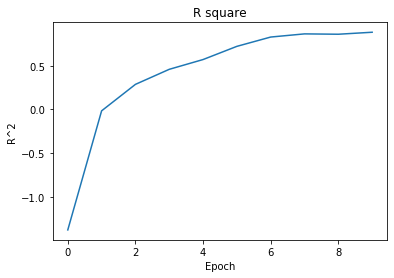

In [0]:
#		3.3.1 학습에 대한 mean_absolute_error 확인.

plot_mae(hist)
plot_r2(hist)

In [0]:
#		3.3.2 trainset에 의한 과거 data의 예측 입국자 count 

predit_y = model.predict([train_x,train_news_x])
predit_y,predit_y.shape

(array([[ 8166.213  ,  8175.3535 ,  8809.898  , ...,  9648.949  ,
          8905.425  ,  8881.696  ],
        [10958.873  , 10957.378  , 11825.8    , ..., 12999.796  ,
         11978.215  , 12022.246  ],
        [13880.482  , 13869.52   , 15029.928  , ..., 16479.72   ,
         15223.743  , 15395.3545 ],
        ...,
        [  617.5597 ,   639.03894,   628.35315, ...,   405.79144,
           364.02985,   325.93152],
        [  604.6073 ,   629.00525,   612.1487 , ...,   401.90808,
           368.4408 ,   329.87842],
        [  592.45044,   616.7271 ,   597.4231 , ...,   399.01672,
           369.0478 ,   330.30753]], dtype=float32),
 (137, 15))

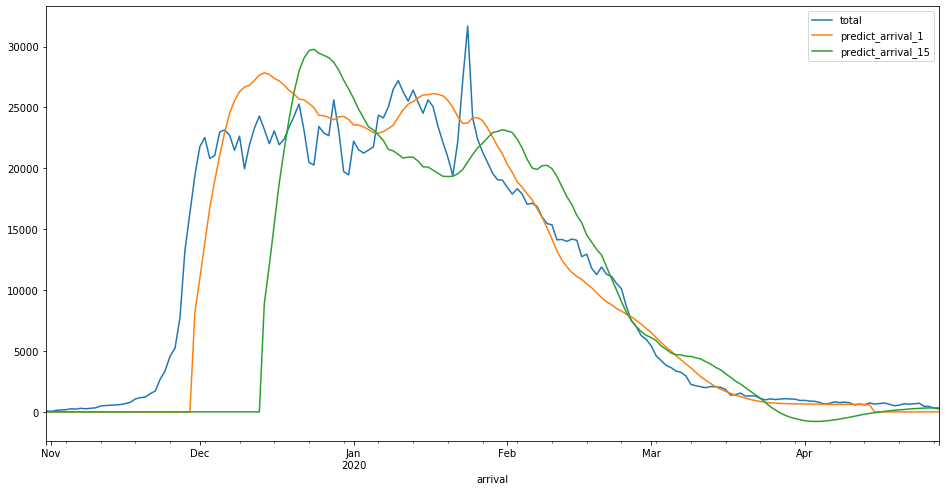

In [0]:
# window와 forecast_days에 의해 실제 날자와 차이나는 부분의 보정 처리...
compare_backdata(predit_y)

In [0]:
# 	3.4  향후 15일 예측
# 		3.4.1 testset (마지막 30일)의 inference

predit_y = model.predict([test_x,test_news_x])
predit_y,predit_y.shape

(array([[470.35056, 483.44962, 466.5027 , 427.92148, 458.34576, 423.5922 ,
         367.374  , 438.0581 , 391.18292, 390.96173, 404.6571 , 372.94894,
         335.53146, 343.28748, 321.39862]], dtype=float32),
 (1, 15))

,date,roaming register forecate,immigrantion forecast
0,2020-04-29,470.350555,1959
1,2020-04-30,483.449615,2014
2,2020-05-01,466.502686,1943
3,2020-05-02,427.921478,1783
4,2020-05-03,458.345764,1909
5,2020-05-04,423.592194,1764
6,2020-05-05,367.373993,1530
7,2020-05-06,438.058105,1825
8,2020-05-07,391.182922,1629
9,2020-05-08,390.961731,1629


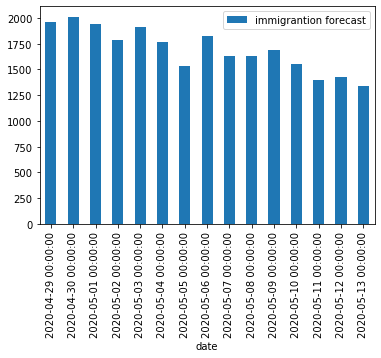

In [0]:
# 		3.4.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출

display_result(predit_y)

In [0]:
#	3.5 ensemble에 의한 일관된 결과 예측
#		3.5.1 ensemble model 생성

# 일관된 예측 결과를 만들기 위해, 동일 모델 10개의 앙상블 처리
# 시간 무지 오래 걸림 식사하고 오세요~
# 밥먹고 왔는데 중간에 실패 (Resource exhaustion) 되어 있을 수 있음...
# 너무 오래 걸리면, epoch=200 을 조정 한다.
import dill

ensemble = []
for i in range(2):
  model,hist = train_combined_model(i+1,epochs=2,verbose=0)
  ensemble.append(model)
    
print("Wait! saving model...")    
file = open("ensemble.mdl", 'wb')
dill.dump(ensemble, file)
file.close()
        
print("Complete!!")


1 th Trial
learning:[==] 2/2 {'loss': 106064724.20437956, 'mae': 8264.592, 'acc': 0.03649635}
2 th Trial
learning:[==] 2/2 {'loss': 93272686.3649635, 'mae': 7662.4473, 'acc': 0.02189781}94}
Wait! saving model...
Complete!!


In [0]:
if True == 1:
    print("load from model file...")
    file = open("ensemble.mdl", 'rb')
    ensemble = dill.load(file)
    file.close()

# 		ensemble_predict method define~
def ensemble_predict(input_roam,input_news):

    ensemble_predit_y =  np.asarray([m.predict([input_roam,input_news]) for m in ensemble])
    predit_y = np.mean(ensemble_predit_y,axis=0)
    return predit_y  

load from model file...


In [0]:
# trainset에 의한 과거 data의 예측 입국자 count 

predit_y = ensemble_predict(train_x,train_news_x)
predit_y,predit_y.shape

(array([[1454.8618, 1341.3677, 1642.5879, ..., 1517.7333, 1477.5427,
         1275.5654],
        [1881.94  , 1736.8428, 2119.0366, ..., 1988.1199, 1928.3378,
         1646.5934],
        [2390.962 , 2196.547 , 2680.6392, ..., 2554.4556, 2453.9478,
         2121.4321],
        ...,
        [1690.4011, 1610.4551, 1427.3438, ..., 1220.7158, 1175.4958,
         1329.4995],
        [1601.1267, 1528.0276, 1360.685 , ..., 1165.6377, 1122.4569,
         1260.7192],
        [1516.5452, 1458.0227, 1296.9839, ..., 1117.3247, 1073.4426,
         1195.729 ]], dtype=float32),
 (137, 15))

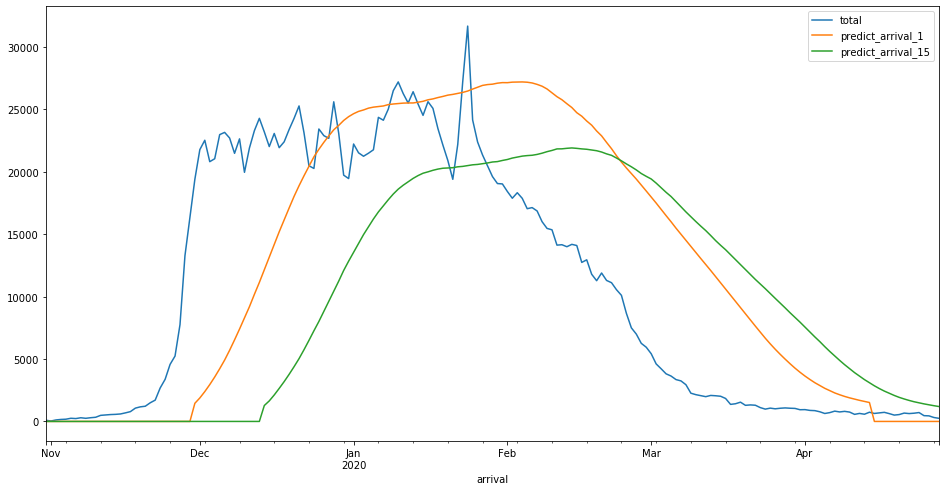

In [0]:
compare_backdata(predit_y)

In [0]:
# 
test_x = test_x.reshape(-1,window,size)
test_news_x = test_news_x.reshape(-1,max_buz_per_day,vec_size,news_window)

predit_y = ensemble_predict(test_x,test_news_x)
predit_y, predit_y.shape

(array([[682.4151 , 709.5459 , 620.25616, 255.07553, 449.54132, 558.4869 ,
         488.46152, 724.5994 , 557.08655, 596.8591 , 696.68146, 423.2028 ,
         453.44028, 647.7956 , 311.1008 ]], dtype=float32),
 (1, 15))

,date,roaming register forecate,immigrantion forecast
0,2020-04-29,682.415100,2843
1,2020-04-30,709.545898,2956
2,2020-05-01,620.256165,2584
3,2020-05-02,255.075531,1062
4,2020-05-03,449.541321,1873
5,2020-05-04,558.486877,2327
6,2020-05-05,488.461517,2035
7,2020-05-06,724.599426,3019
8,2020-05-07,557.086548,2321
9,2020-05-08,596.859070,2486


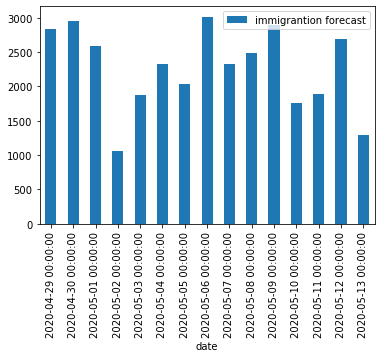

In [0]:
#		3.5.2 최종 결과
display_result(predit_y)